In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from autograd import grad
import autograd.numpy as np
import scipy.integrate

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Functions to generate the training trajectories

In [3]:
e3 = np.array([0,0,1]) # third axis of the intertial frame

In [4]:
def Massm(nop,m):
  """
  Mass matrix collecting the terms mij in the matrix defining the kinetic energy

  Parameters
  ----------
  nop : int
      number of pendulums
  m : float
  masses of the pendulums (supposed to be all the same in this case)

  Returns
  -------
  M: numpy.ndarray
     Mass matrix

  """
  M=np.zeros((nop,nop))
  for i in range(nop):
    M[i,i]=(nop-i)*m
    for j in range(i):
      M[i,j] = (nop-i)*m
    for k in range(i):
      M[k,i]=M[i,j]

  return M


def hat(q):
  """"
  Isomorphism bewteen R3 and so(3). It returns the skew symmetric matrix hat(q) associated to the vector q, 
  such that hat(a)b=axb for all 3-component vectors a and b, with "x" the cross product

  Parameters
  ----------
  q : numpy.ndarray
      3-component vector

  Returns
  -------
  hat(q): numpy.ndarray
          3x3 skew-symmetric matrix (element of the Lie algebra so(3))

  """
  return np.array([[0.,-q[2],q[1]],[q[2],0.,-q[0]],[-q[1],q[0],0.]])


In [5]:
def MatrR(q):
  """
  Matrix defining the quadratic kinetic energy

  Parameters
  ----------
  q : numpy.ndarray
      3N-component vector of coordinates, with N the number of pendulums
    
  Returns
  -------
  R : numpy.ndarray
      3Nx3N matrix defining the kinetic energy, with N the number of pendulums
  """
  m = 1.
  L = 1.
  n = len(q)
  nn = int(n/3)
  M=Massm(nn,m)
  R = M[0,0]*np.eye(3)
  for j in range(1,nn):
        R = np.concatenate((R,M[0,j]*(np.eye(3)-np.outer(q[0:3],q[0:3]))), axis=1)
  for i in range(1,nn):
    for j in range(nn):
      if j in [i]:
        R = np.concatenate((R,M[i,i]*np.eye(3)), axis=1)
      else:
        R = np.concatenate((R,M[i,j]*(np.eye(3)-np.outer(q[3*i:3*i+3],q[3*i:3*i+3]))), axis=1)
  row=R[0:3,0:n]
  for i in range(1,nn):
    row = np.concatenate((row,R[0:3,n*i:n*i+n]), axis=0)
  return row

Derivatives of the Hamiltonian

In [6]:
def Hp(z): 
  """
  Gradient of the Hamiltonian with respect to the conjugate momenta

  Parameters
  ----------
  z : numpy.ndarray
      6N-component vector of generalized coordinates and momenta, 
      with N the number of pendulums
    
  Returns
  -------
  Hp : numpy.ndarray
       3N-component vector, with N the number of pendulums

  """
  nop = int(len(z)/6)
  q = z[0:3]
  p = z[3:6]
  for i in range(1,nop):
    q = np.concatenate((q,z[3*(2*i):3*(2*i+1)]))
    #print('q=',q)
    p = np.concatenate((p,z[3*(2*i+1):3*(2*i+2)]))
    #print('p=',p)
  return 0.5 * np.linalg.solve(MatrR(q),p) + 0.5 * np.linalg.solve(MatrR(q).T,p)


def Hq(z):
  """
  Gradient of the Hamiltonian with respect to the configuration variables

  Parameters
  ----------
  z : numpy.ndarray
      6N-component vector of configuration variables and conjugate momenta, 
      with N the number of pendulums
    
  Returns
  -------
  Hp : numpy.ndarray
       3N-component vector, with N the number of pendulums

  """
  nop = int(len(z)/6)
  g = 1
  m = 1
  L = 1
  q = z[0:3]
  p = z[3:6]
  for i in range(1,nop):
    q = np.concatenate((q,z[3*(2*i):3*(2*i+1)]))
    p = np.concatenate((p,z[3*(2*i+1):3*(2*i+2)]))
  func = lambda v: np.dot(p,np.linalg.solve(MatrR(v),p))
  nablaq = grad(func)
  nablaqq = nablaq(q)  
  res = m*g*L*e3*nop
  for j in range (2,nop+1):
    res = np.concatenate((res, (nop-j+1)*m*L*g*e3))
  return 0.5*nablaqq + res

Parameters for the generation of the training trajectories

In [7]:
T = 0.1 # final time
M = 5 # number of time steps
time = np.linspace(0,T,M) # M evenly spaced times over the interval [0, T]
dt = time[1] - time[0]
s = 3 # dimensionality of the problem (dynamics with ambient space R^2s)
N = 500 # number of initial conditions (i.e. number of training trajectories)

nop = 2 #Number of pundulums

Definition of the Hamiltonian vector field of interest

In [8]:
def dynamics(t,z):
  """
  System of ODEs defining the dynamics

  Parameters
  ----------
  t : float
      1-D independent variable (time)
      
  z : numpy.ndarray
      6N-component vector of configuration variables and conjugate momenta, 
      with N the number of pendulums

  Returns
  -------
  vec : numpy.ndarray
        3N-component vector, with N the number of pendulums

  """  
  nop = int(len(z)/6)
  vec = 0*z
  I = np.eye(3)

  q = z[0:3]
  p = z[3:6] 
  vec[:3] = (I-np.outer(q,q))@Hp(z)[:3]
  vec[3:6] = -(I-np.outer(q,q))@Hq(z)[:3] + np.cross(Hp(z)[:3],np.cross(p,q))

  for i in range(1,nop):
    q = z[3*(2*i):3*(2*i+1)]
    p = z[3*(2*i+1):3*(2*i+2)] 
    vec[3*(2*i):3*(2*i+1)]= (I-np.outer(q,q))@Hp(z)[3*i:3*(i+1)]
    vec[3*(2*i+1):3*(2*i+2)] = -(I-np.outer(q,q))@Hq(z)[3*i:3*(i+1)] + np.cross(Hp(z)[3*i:3*(i+1)],np.cross(p,q))
  
  return vec

Generation of training and test trajectories

In [9]:
# initialization of the trajectories
trajectories = np.zeros([N,2*s*nop,M])

# initial conditions
q = np.zeros(int(3*nop))
p = np.zeros(int(3*nop))
for i in range(N):
  for j in range(nop):
    nrand = np.random.randn(3)
    q = nrand/np.linalg.norm(nrand,2)
    trajectories[i,3*2*j:3*(2*j+1),0] = q 
    supp = np.random.rand(3)
    trajectories[i,3*(2*j+1):3*(2*j+2),0] = np.cross(q,supp)

# Generation of the dataset with RK45 (default)
for j in range(N):
  trajectories[j,:,:] = scipy.integrate.solve_ivp(dynamics,[0,T],trajectories[j,:,0],method='RK45',t_eval = time,rtol=1e-3,atol=1e-5).y

Visualization of the trainining and test trajectories

In [10]:
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

a = 1 * np.outer(np.cos(u), np.sin(v))
b = 1 * np.outer(np.sin(u), np.sin(v))
c = 1 * np.outer(np.ones(np.size(u)), np.cos(v))

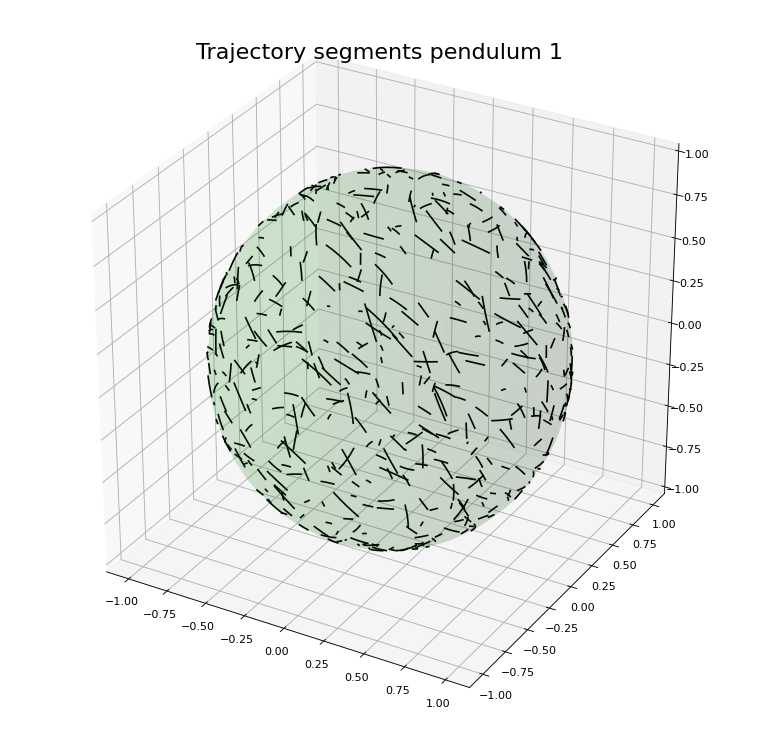

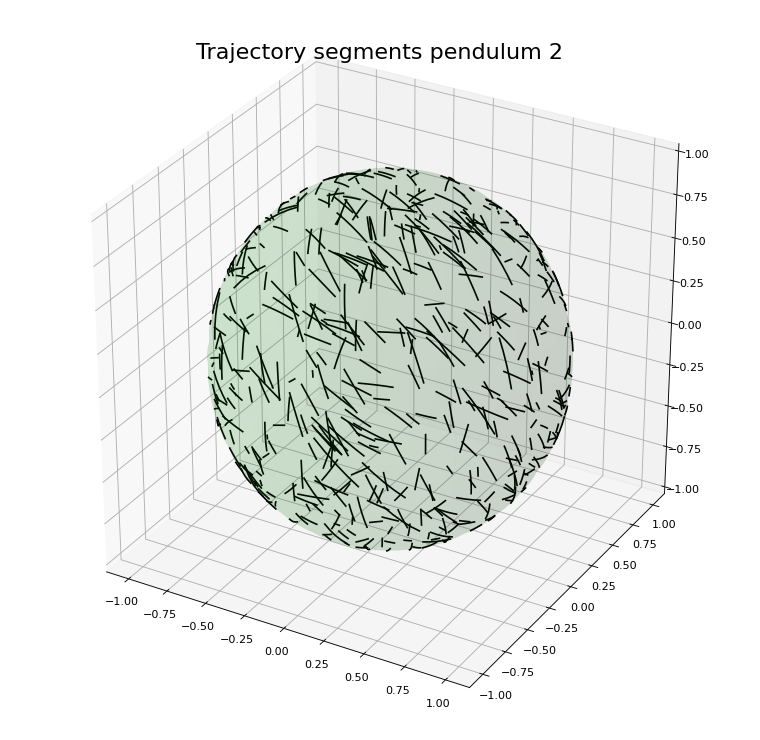

In [11]:
for num in range(nop):
  fig = plt.figure(figsize=(12,12), dpi=80)
  ax = plt.axes(projection='3d')
  ax.plot_surface(a, b, c,  rstride=4, cstride=4, color='g', linewidth=0, alpha=0.09)
  for i in range(N):
    ax.plot3D(trajectories[i,6*num,:],trajectories[i,6*num+1,:],trajectories[i,6*num+2,:],'k-')
  plt.title(f"Trajectory segments pendulum {num+1}",fontsize=20)
  plt.show()

# Building the neural network

In [13]:
X = trajectories[:,:,0] # trajectories in the phase space at time t=0 (intial comnditions)
Y = trajectories[:,:,1:M+1] # trajectory solutions at M-1 evenly spaced times over the interval [dt, T] with dt = T/(M-1)

In [14]:
# definition of the dataset with pytorch

from torch.utils.data import Dataset, DataLoader
class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.from_numpy(x.astype(np.float32))
    self.y = torch.from_numpy(y.astype(np.float32))
    self.length = self.x.shape[0]
 
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]
  def __len__(self):
    return self.length

trainset = dataset(X,Y)

In [15]:
batch_size = 80
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

In [16]:
K = 100 # number of neurons of the hidden layers for the potential energy
nlayers = 2 # number of layers of the NN

In [17]:
id1=np.arange(0,s*nop,s)
id2=np.arange(1,s*nop,s)
id3=np.arange(2,s*nop,s)

In [18]:
class Hamiltonian(nn.Module): # the neural network module contains layers and encapsulates paramenters
    def __init__(self, ):
        super(Hamiltonian, self).__init__()
        
        self.IV = nn.Linear(s*nop,K) # linear layer (s*nop-dimnesional input, K-dimensional output)
        self.nl = nn.Tanh() # nonlinear activation function
        self.OV = nn.Linear(K,1,bias=False) # linear output layer (K-dimnesional input, 1-dimensional output)

        ll = []
        ll.append(self.IV)
        ll.append(self.nl)
        for i in range(nlayers):
          ll.append(nn.Linear(K,K))
          ll.append(self.nl)
        ll.append(self.OV)

        # the sequential module connects the modules in ll in a cascading way, 
        # chaining outputs to inputs sequentially for each subsequent module 
        # and returning the output of the ladt module
        self.seq = nn.Sequential(*ll)

        # parameters in the neural network used to define the mass matrix in the kinetic energy
        self.Gamma = torch.nn.Parameter(data=torch.rand(nop,nop))
        self.B = torch.nn.Parameter(data=torch.rand(nop))
        self.func = nn.ReLU()

    # Definition of the mass matrix
    def MassMat(self,X):
        """
        Mass matrix defining the kinetic energy quadratic function

        Parameters
        ----------
        X: torch.Tensor
           training trajectory points in input, with shape [batch size, nop*2s]
        Returns
        -------
        row : torch.Tensor
              Mass matrix to be learned by the neural network,  with shape [batch size, nop*s, nop*s]

        """
        nop = int(X.size(dim=1)/6)
        q = X[:,:3]
        for j in range(1,nop):
          q = torch.cat([q, X[:,3*2*j:3*(2*j+1)]], axis=1)
        M = torch.transpose(self.Gamma,0,1)@self.Gamma + torch.diag(self.B)**2
        I = torch.eye(3).unsqueeze(0).repeat(len(q),1,1).to(device)
        R = M[0,0] * I
        for j in range(1,nop):
          R = torch.cat((R,M[0,j]*(I-torch.einsum('ij,ik->ijk',q[:,:3],q[:,:3]))),axis=2)
        for i in range(1,nop):
          for j in range(nop):
            if j == i:
              R = torch.cat((R,M[i,i]*I),axis=2)
            else:
              R = torch.cat((R,M[i,j]*(I-torch.einsum('ij,ik->ijk',q[:,3*i:3*i+3],q[:,3*i:3*i+3]))),axis=2)
        n = nop * s
        row=R[:,0:3,0:n]
        for i in range(1,nop):
          row = torch.cat((row,R[:,0:3,n*i:n*(i+1)]),axis=1)
        return row

    # Modelling of the Kinetic energy as a bilinear form  
    def Kinetic(self, X):
        """
        Kinetic energy in the Hamiltonian function

        Parameters
        ----------
        X: torch.Tensor
           training trajectory points in input, with shape [batch size, nop*2s]

        Returns
        -------
        row : torch.Tensor
              Kinetic energy, with shape [batch size, 1]
              
        """ 
        nop = int(X.size(dim=1)/6)
        id = torch.eye(nop,nop)
        ref = torch.ones(3,3)
        R = torch.kron(id, ref).to(device)
        U = torch.ones(3*nop,3*nop).to(device)
        p = X[:,3:6]
        for j in range(1,nop):
          p = torch.cat([p, X[:,3*(2*j+1):3*(2*j+2)]], axis=1)
        MM = self.MassMat(X) 
        k = (0.5 * torch.einsum('ij,ij->i',p,torch.linalg.solve(MM,p))).unsqueeze(1) # q dependent component
        return k
    
    # Modelling of the potential energy as a feed-forward neural network
    def Potential(self, X):
        """
        Potential energy in the Hamiltonian function

        Parameters
        ----------
        X: torch.Tensor
           training trajectory points in input, with shape [batch size, nop*2s] 

        Returns
        -------
        row : torch.Tensor
              Potential energy, with shape [batch size, 1]
              
        """ 
        nop = int(X.size(dim=1)/6)
        q = X[:,:3]
        for j in range(1,nop):
          q = torch.cat([q, X[:,3*2*j:3*(2*j+1)]], axis=1)

        v = self.seq(q)
        return v

    # Sum of the contributions to get the approximated Hamiltonian energy
    def forward(self, X):
        """
        Forward function that receives a tensor containing the input (trajectory points in the phase space) 
        and returns a tensor containing a scalar output (Hamiltonian)).

        Parameters
        ----------
        X: torch.Tensor
           training trajectory points in input, with shape [batch size, nop*2s]

        Returns
        -------
        o : torch.Tensor
            Value of the Hamiltonian, with shape [batch size, 1]

        """ 
        o = self.Potential(X) + self.Kinetic(X)
        return o

In [19]:
Ham = Hamiltonian()
Ham.to(device)

Hamiltonian(
  (IV): Linear(in_features=6, out_features=100, bias=True)
  (nl): Tanh()
  (OV): Linear(in_features=100, out_features=1, bias=False)
  (seq): Sequential(
    (0): Linear(in_features=6, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Tanh()
    (6): Linear(in_features=100, out_features=1, bias=False)
  )
  (func): ReLU()
)

In [20]:
import torch.optim as optim

criterion = nn.MSELoss() # defining the Loss function as a mean squared error function
optimizer = torch.optim.Adam(Ham.parameters(),lr=0.01) # Adam algorithm as optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# Training Neural Network

### Functions required for Lie group integrators, written using PyTorch methods, so that inputs and outputs are PyTorch tensors

In [21]:
def hatNN(q):
  """
  It returns the skew symmetric matrix associated to the vector q, such
  that hat(a)b=axb for all 3-component vectors a and b, with "x" the cross product

  Parameters
  ----------
  q: torch.Tensor
     coordinates of the training trajectory points, with shape [batch size, s], s=3

  Returns
  -------
  res : torch.Tensor
        skew symmetric matrix associated to each vector q in the batch, with shape [batch size, s, s], s=3

  """ 
  zz = torch.zeros([len(q),1]).to(device)  #len(q) number of points in the batch
  row1 = torch.cat([zz,-q[:,2:3],q[:,1:2]],axis=1).unsqueeze(1).to(device)
  row2 = torch.cat([q[:,2:3],zz,-q[:,0:1]],axis=1).unsqueeze(1).to(device)
  row3 = torch.cat([-q[:,1:2],q[:,0:1],zz],axis=1).unsqueeze(1).to(device)
  res = torch.cat([row1,row2,row3],axis=1).to(device) # 3d tensor
  return res


def fManiAlgebraNN(H,z):
  """
  Funtion f from the manifold M (phase space of the system) to the Lie algebra of the group acting on M

  Parameters
  ----------
  H: torch.Tensor
     Hamiltonian function

  z: torch.Tensor
     training trajectory points, with size [batch size, nop*2s]

  Returns
  -------
  ff : torch.Tensor
       map f : M -> g (Lie algebra)

  """ 
  nop = z.size(dim=1)//6
  HamVal = torch.sum(H(z)).to(device)
  dH = torch.autograd.grad(HamVal, z, create_graph=True)[0].to(device)

  q = z[:,0:3]
  p = z[:,3:6]
  dHq = dH[:,0:3]
  dHp = dH[:,3:6]
  xi = torch.cross(q,dHp)
  eta = torch.cross(dHq,q)+torch.cross(dHp,p)
  ff = torch.cat([xi,eta],axis=1).to(device)

  for i in range(1,nop):
    q = z[:,3*(2*i):3*(2*i+1)]
    p = z[:,3*(2*i+1):3*(2*i+2)]
    dHq = dH[:,3*(2*i):3*(2*i+1)]
    dHp = dH[:,3*(2*i+1):3*(2*i+2)]
    xi = torch.cross(q,dHp)
    eta = torch.cross(dHq,q)+torch.cross(dHp,p)
    ff = torch.cat([ff,xi,eta],axis=1)

  return ff


def expso3NN(x):
  """
  Exponential map on SO(3)

  Parameters
  ----------
  x: torch.Tensor (float32)
     element of the lie algebra so(3), represented as a vector with 3 components.

  Returns
  -------
  expA : torch.Tensor
         element of the group SO(3), i.e. 3x3 rotation matrix

  """ 
  a = torch.linalg.norm(x,axis=1).to(device)
  tol = 10**(-10)
  aa = ((a>=tol)*1)
  dd = ((a>0)*1)*((a<tol)*1)
  expA = torch.eye(3).unsqueeze(0).repeat(len(x),1,1).to(device)
  cc = aa.nonzero(as_tuple=True)
  #if a>tol:
  A = torch.zeros(len(expA)).to(device)
  B = torch.zeros(len(expA)).to(device)
  A[cc] = (torch.div(torch.sin(a[cc]),a[cc]))
  B[cc] = ((1-torch.cos(a[cc]))/a[cc]**2)

  expA += torch.einsum('i,ijk->ijk',A,hatNN(x)) + torch.einsum('i,ijk->ijk',B,torch.einsum('ijk,ikl->ijl',hatNN(x),hatNN(x)))

  #if a>0 and a<tol:
  mult1 = 1 * dd
  mult2 = 1/2 * dd
  mult3 = 1/6 * dd
  mult4 = 1/24 * dd

  pow1 = hatNN(x)
  
  pow2 = (torch.einsum('ijk,ikl->ijl',pow1,pow1))
  pow3 = (torch.einsum('ijk,ikl->ijl',pow2,pow1))
  pow4 = (torch.einsum('ijk,ikl->ijl',pow3,pow1))
  
  expA += torch.einsum('i,ijk->ijk',mult1,pow1) + torch.einsum('i,ijk->ijk',mult2,pow2) + torch.einsum('i,ijk->ijk',mult3,pow3) + torch.einsum('i,ijk->ijk',mult4,pow4)
  return expA


def expse3NN(input):
  """
  Exponential map on SE(3)

  Parameters
  ----------
  x: torch.Tensor (float32)
     element of the lie algebra se(3) represented as 6-component vector,
     i.e. as a pair (u,v) with with the 3-component vector u corresponding 
     to a skew symmetric matrix hat(u) and the 3-component vector v
     corresponding to the translational part.

  Returns
  -------
  expA : torch.Tensor
         element of the group SE(3), represented as a 3x4 matrix [A, b], 
         with A 3x3 rotation matrix and b 3-component translation vector.

  """ 
  u = input[:,:3]
  v = input[:,3:]
  a = torch.linalg.norm(u,axis=1).to(device)
  tol = 1e-10;  

  cc = a>=tol + 0
  ee = (a<tol)*(a>0) + 0

  V = torch.eye(3).unsqueeze(0).repeat(len(input),1,1).to(device) #the right matrix if a = 0, then we increment with the right quantities 

  #if a>tol:
  A = cc*(torch.div(torch.sin(a),a))
  B = cc*((1-torch.cos(a))/a**2)
  C = cc*(torch.div(1-A,a**2))

  V += torch.einsum('i,ijk->ijk',B,hatNN(u)) + torch.einsum('i,ijk->ijk',C,torch.einsum('ijk,ikl->ijl',hatNN(u),hatNN(u)))
  
  #if 0<a<tol:
  Blow = ee*(0.5-a**2/24 + a**4/720 - a**6/40320)
  Clow = ee*(1/6-a**2/120+a**4/5040-a**6/362880)
  V += torch.einsum('i,ijk->ijk',Blow,hatNN(u)) + torch.einsum('i,ijk->ijk',Clow,torch.einsum('ijk,ikl->ijl',hatNN(u),hatNN(u)))

  expA = torch.cat([expso3NN(u), torch.einsum('ijk,ik->ij',V,v).unsqueeze(2)],axis=2).to(device)

  return expA


def expse3NNn(input):
  """
  Concatenate exponentials on SE(3) in one tensor

  Parameters
  ----------
  input: torch.Tensor

  Returns
  -------
  out : torch.Tensor

  """ 
  dim0 = input.size(dim=0)
  dim1 = input.size(dim=1)
  nop = int(dim1/6)
  out = expse3NN(input[:,0:6])
  for i in range(1,nop):
    out = torch.cat([out, expse3NN(input[:,6*i:6*(i+1)])], axis=2).to(device)
  return out


def actionSE3NN(g, z):
  """
  Group action of SE3 on TS^2

  Parameters
  ----------
  g: torch.Tensor
     element of the group SE3 

  z : torch.Tensor 
      trajectory point in the phase space

  Returns
  -------
  out = torch.Tensor

  """ 
  R = g[:,:,:3]
  r = g[:,:,3]
  q = z[:,0:3]
  p = z[:,3:]
  qq = torch.einsum('ijk,ik->ij',R,q)
  pp = torch.einsum('ijk,ik->ij',R,p) + torch.einsum('ijk,ik->ij',hatNN(r),qq)
  out = torch.cat([qq,pp],axis=1).to(device)
  return out


def actionse3NNn(g, z):
  """
  Concatenate se3 actions

  Parameters
  ----------
  g : torch.Tensor
      elements of the group SE3 

  z : torch.Tensor
      trajectory points in the phase space

  Returns
  -------
  out : torch.Tensor
 
  """ 
  dim0 = z.size(dim=0)
  dim1 = z.size(dim=1)
  nop = int(dim1/6)
  out = actionSE3NN(g[:,:,0:4],z[:,0:6])
  for i in range(1,nop):
     out = torch.cat([out, actionSE3NN(g[:,:,4*i:4*(i+1)],z[:,6*i:6*(i+1)])], axis=1).to(device)
  return out

In [22]:
def LieEulerNN(x0,f,h,cc,H):
  """
  Lie Euler integrator

  Parameters
  ----------
  x0 : torch.Tensor
       soltuion at time t0

  f : function handle
      map f from the manifold M to the Lie algebra of the group acting on M

  h : float
      time step

  cc : int
       M-1

  H : neural network class
      Hamiltonian function

  Returns
  -------
  sol : solution at time t1=t0+h
 
  """ 
  num = len(x0) # number of points (bacth size)
  sol = torch.zeros([len(x0[:,0]),len(x0[0,:]),cc]).to(device)
  z  = x0
  times = 1
  h = h/times
  for i in range(cc):
    for j in range(times):
      z =  actionse3NNn(expse3NNn(h*f(H,z)),z)
    sol[:,:,i] = z
  return sol

In [23]:
def CF4NN(x0,f,h,cc,H):
  """
  Lie group commutator free integrator of order 4

  Parameters
  ----------
  x0 : torch.Tensor
       soltuion at time t0

  f : function handle
      map f from the manifold M to the Lie algebra of the group acting on M

  h : float
      time step

  cc : int
       M-1

  H : neural network class
      Hamiltonian function

  Returns
  -------
  sol : solution at time t1=t0+h
 
  """ 
  num = len(x0) #number of points
  sol = torch.zeros([len(x0[:,0]),len(x0[0,:]),cc]).to(device)
  z  = x0
  times = 2
  h = h/times
  for i in range(cc):
    for j in range(times):
      M1 = z
      A1 = f(H,M1)
      M2 = actionse3NNn(expse3NNn(0.5*h*A1),z)
      A2 = f(H,M2)
      M3 = actionse3NNn(expse3NNn(0.5*h*A2),z)
      A3 = f(H,M3)
      M4 = actionse3NNn(expse3NNn(h*A3-0.5*h*A1),M2)
      A4 = f(H,M4)
      mhalf = actionse3NNn(expse3NNn(1/12*h*(3*A1+2*A2+2*A3-A4)),z)  
      z = actionse3NNn(expse3NNn(1/12*h*(-A1+2*A2+2*A3+3*A4)),mhalf)
    sol[:,:,i] = z

  return sol

### Classical Runge-Kutta integrators

In [24]:
# Characterization of the Hamiltonian vector field with Hamiltonian given by HH
def predictedVF(x,HH):
  """
  Vector field predicted by using the output of the neural network as the Hamiltonian

  Parameters
  ----------
  x : torch.Tensor
      soltuion at time t0

  HH : function handle
       Hamiltonian

  Returns
  -------
  vec : torch.Tensor
        vector field (Hamlton equations)

  """
  z = x.clone().requires_grad_().to(device)
  nop = int(len(z[0])/6)
  HamVal = torch.sum(HH(z)) # H sarà la rete ...fatto per prendere il gradiente
  dH = torch.autograd.grad(HamVal, z, create_graph=True)[0]

  vec = torch.zeros(z.shape).to(device)
  q = z[:,0:3]
  p = z[:,3:6]
  dHq = dH[:,:3]
  dHp = dH[:,3:6]
  for i in range(1,nop):
    q = torch.concat((q,z[:,3*(2*i):3*(2*i+1)]),dim=1)
    p = torch.concat((p,z[:,3*(2*i+1):3*(2*i+2)]),dim=1)
    dHq = torch.concat((dHq,dH[:,3*(2*i):3*(2*i+1)]),dim=1)
    dHp = torch.concat((dHp,dH[:,3*(2*i+1):3*(2*i+2)]),dim=1)

  I = torch.eye(3).repeat(len(z),1,1).to(device)
  # part for the first pendulum
  
  for i in range(nop):
    mat1 = (I-torch.einsum('ij,ik->ijk',q[:,3*i:3*(i+1)],q[:,3*i:3*(i+1)]))
    dqdt = torch.einsum('ijk,ik->ij',mat1,dHp[:,3*i:3*(i+1)])
    part1 = -torch.einsum('ijk,ik->ij',mat1,dHq[:,3*i:3*(i+1)])
    part2 = torch.cross(dHp[:,3*i:3*(i+1)],torch.cross(p[:,3*i:3*(i+1)],q[:,3*i:3*(i+1)]))
    dpdt = part1 + part2
    vec[:,6*i:6*(i+1)] = torch.concat([dqdt,dpdt],dim=1)

  return vec

In [25]:
def ExpEuler(x0,h,cc,H):
  """
  Explicit Euler method

  Parameters
  ----------
  x0 : torch.Tensor
       soltuion at time t0

  f : function handle
      map f from the manifold M to the Lie algebra of the group acting on M

  h : float
      time step

  cc : int
       M-1

  H : neural network class
      Hamiltonian function

  Returns
  -------
  sol : solution at time t1=t0+h

  """
  sol = torch.zeros([len(x0[:,0]),len(x0[0,:]),cc]).to(device)
  z  = x0.clone()
  z.requires_grad_()
  for i in range(cc):
    z = z + h * predictedVF(z,H) 
    sol[:,:,i] = z.to(device)
  
  return(sol) #stored trajectories


def RK4(x0,h,cc,H):
  """
  Runge-Kutta method of order 4

  Parameters
  ----------
  x0 : torch.Tensor
       soltuion at time t0

  f : function handle
      map f from the manifold M to the Lie algebra of the group acting on M

  h : float
      time step

  cc : int
       M-1

  H : neural network class
      Hamiltonian function

  Returns
  -------
  sol : solution at time t1=t0+h
 
  """ 
  sol = torch.zeros([len(x0[:,0]),len(x0[0,:]),cc]).to(device)
  z  = x0.clone().requires_grad_()
  for i in range(cc):
    k1 = predictedVF(z,H) 
    k2 = predictedVF(z + 0.5 * h * k1, H)
    k3 = predictedVF(z + 0.5 * h * k2, H)
    k4 = predictedVF(z + h * k3, H)
    z = z + h/6 * (k1 + 2 * k2 + 2 * k3 + k4)
    sol[:,:,i] = z.to(device)
  return(sol) #stored trajectories


### Training of the network

In [26]:
# Choice of the integrator
integrator = CF4NN
isLieGroupMethod = True # is integrator a Lie group method?

In [27]:
checkpoint = 20

for epoch in range(100):

    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        inputs.requires_grad_()
        optimizer.zero_grad()

        if isLieGroupMethod:
          predicted = integrator(inputs,fManiAlgebraNN,dt,M-1,Ham)
        else:
          predicted = integrator(inputs,dt,M-1,Ham)

        loss = criterion(predicted, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % checkpoint == 0:  
            print('[%d, %5d] loss: %.10f' %
                  (epoch + 1, i + 1, running_loss / checkpoint))
            running_loss = 0.0

    scheduler.step()
    if epoch%10 == 0 and epoch>0:
      lr=optimizer.param_groups[0]["lr"]
      print(f"\n\nLR: {lr}, EPOCH: {epoch}\n\n")

print('Finished Training')

[1,     1] loss: 0.0001664412
[2,     1] loss: 0.0000459875
[3,     1] loss: 0.0000197340
[4,     1] loss: 0.0000120812
[5,     1] loss: 0.0000076165
[6,     1] loss: 0.0000034387
[7,     1] loss: 0.0000010966
[8,     1] loss: 0.0000007205
[9,     1] loss: 0.0000006697
[10,     1] loss: 0.0000004617
[11,     1] loss: 0.0000003696


LR: 0.01, EPOCH: 10


[12,     1] loss: 0.0000003620
[13,     1] loss: 0.0000002056
[14,     1] loss: 0.0000001852
[15,     1] loss: 0.0000001330
[16,     1] loss: 0.0000000919
[17,     1] loss: 0.0000000676
[18,     1] loss: 0.0000000573
[19,     1] loss: 0.0000000506
[20,     1] loss: 0.0000000397
[21,     1] loss: 0.0000000354


LR: 0.01, EPOCH: 20


[22,     1] loss: 0.0000000280
[23,     1] loss: 0.0000000251
[24,     1] loss: 0.0000000198
[25,     1] loss: 0.0000000146
[26,     1] loss: 0.0000000174
[27,     1] loss: 0.0000000129
[28,     1] loss: 0.0000000094
[29,     1] loss: 0.0000000080
[30,     1] loss: 0.0000000071
[31,     1] loss: 0.0000000057


# Evaluating the approximation

with respect to a set of test trajectories

In [28]:
Ham.eval(); # to pass in evaluation mode

In [29]:
def predicted(t,z):
  """
  Vector field predicted by using the evaluated Hamiltonian, t be used in scipy.integrate.solve_ivp
  to get trajectory segments with the evaluated Hamitlonian

  Parameters
  ----------
  t : time
      standard input to use the predicted function in scipi.integrate.solve_ivp

  HH : torch.Tensor
       trajectory point

  Returns
  -------
  vec : torch.Tensor
        vector field (Hamlton equations)

  """
  z = torch.from_numpy(z.astype(np.float32)).requires_grad_()
  z = z.to(device)
  nop = int(len(z)/6)
  
  HamVal = torch.sum(Ham(z.view(1,-1))).to(device)
  dH = torch.autograd.grad(HamVal, z, create_graph=True)[0].detach().cpu().numpy()

  vec = np.zeros(len(z))
  z = z.detach().cpu().numpy()
  q = z[0:3]
  p = z[3:6]
  dHq = dH[:3]
  dHp = dH[3:6]
  for i in range(1,nop):
    q = np.concatenate((q,z[3*(2*i):3*(2*i+1)]))
    p = np.concatenate((p,z[3*(2*i+1):3*(2*i+2)]))
    dHq = np.concatenate((dHq,dH[3*(2*i):3*(2*i+1)]))
    dHp = np.concatenate((dHp,dH[3*(2*i+1):3*(2*i+2)]))

  I = np.eye(3)

  for i in range(nop):
    dqdt = (I-np.outer(q[3*i:3*(i+1)],q[3*i:3*(i+1)]))@dHp[3*i:3*(i+1)]
    part1 = -(I-np.outer(q[3*i:3*(i+1)],q[3*i:3*(i+1)]))@dHq[3*i:3*(i+1)]
    part2 = np.cross(dHp[3*i:3*(i+1)],np.cross(p[3*i:3*(i+1)],q[3*i:3*(i+1)]))
    dpdt = part1 + part2
    vec[6*i:6*(i+1)] = np.concatenate([dqdt,dpdt])
  return vec

Generate test initial conditions

In [30]:
MM = 15
TT = 1
Ntest = 100

predictedTraj = np.zeros([Ntest,2*s*nop,MM])
realTraj = np.zeros([Ntest,2*s*nop,MM])
timeEv = np.linspace(0,TT,MM)

In [31]:
q = np.zeros(int(3*nop))
p = np.zeros(int(3*nop))

for i in range(Ntest):
  for j in range(nop):
    nrand = np.random.randn(3)
    q = nrand/np.linalg.norm(nrand,2)
    predictedTraj[i,3*2*j:3*(2*j+1),0] = q #position # indici: i-esimo punto di dataset, coordinate vettore nello spazio di config, time step
    supp = np.random.rand(3)
    predictedTraj[i,3*(2*j+1):3*(2*j+2),0] = np.cross(q,supp)

realTraj[:,:,0] = predictedTraj[:,:,0]

In [32]:
#Generate the dataset
for j in range(Ntest):
  predictedTraj[j,:,:] = scipy.integrate.solve_ivp(predicted,[0,TT],predictedTraj[j,:,0],method='RK45',t_eval = timeEv,rtol=1e-6,atol=1e-8).y
  realTraj[j,:,:] = scipy.integrate.solve_ivp(dynamics,[0,TT],realTraj[j,:,0],method='RK45',t_eval = timeEv,rtol=1e-6,atol=1e-8).y

In [33]:
u = np.linspace(0, 2*np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v)) # np.outer() -> outer vector product
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))

In [34]:
def set_axes_equal(ax: plt.Axes):
    """Set 3D plot axes to equal scale.

    Make axes of 3D plot have equal scale so that spheres appear as
    spheres and cubes as cubes.  Required since `ax.axis('equal')`
    and `ax.set_aspect('equal')` don't work on 3D.
    """
    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d(),
    ])
    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    _set_axes_radius(ax, origin, radius)

def _set_axes_radius(ax, origin, radius):
    x, y, z = origin
    ax.set_xlim3d([x - radius, x + radius])
    ax.set_ylim3d([y - radius, y + radius])
    ax.set_zlim3d([z - radius, z + radius])

In [35]:
def _set_axes_radius(ax, origin, radius):
    x, y, z = origin
    ax.set_xlim3d([x - radius, x + radius])
    ax.set_ylim3d([y - radius, y + radius])
    ax.set_zlim3d([z - radius, z + radius])

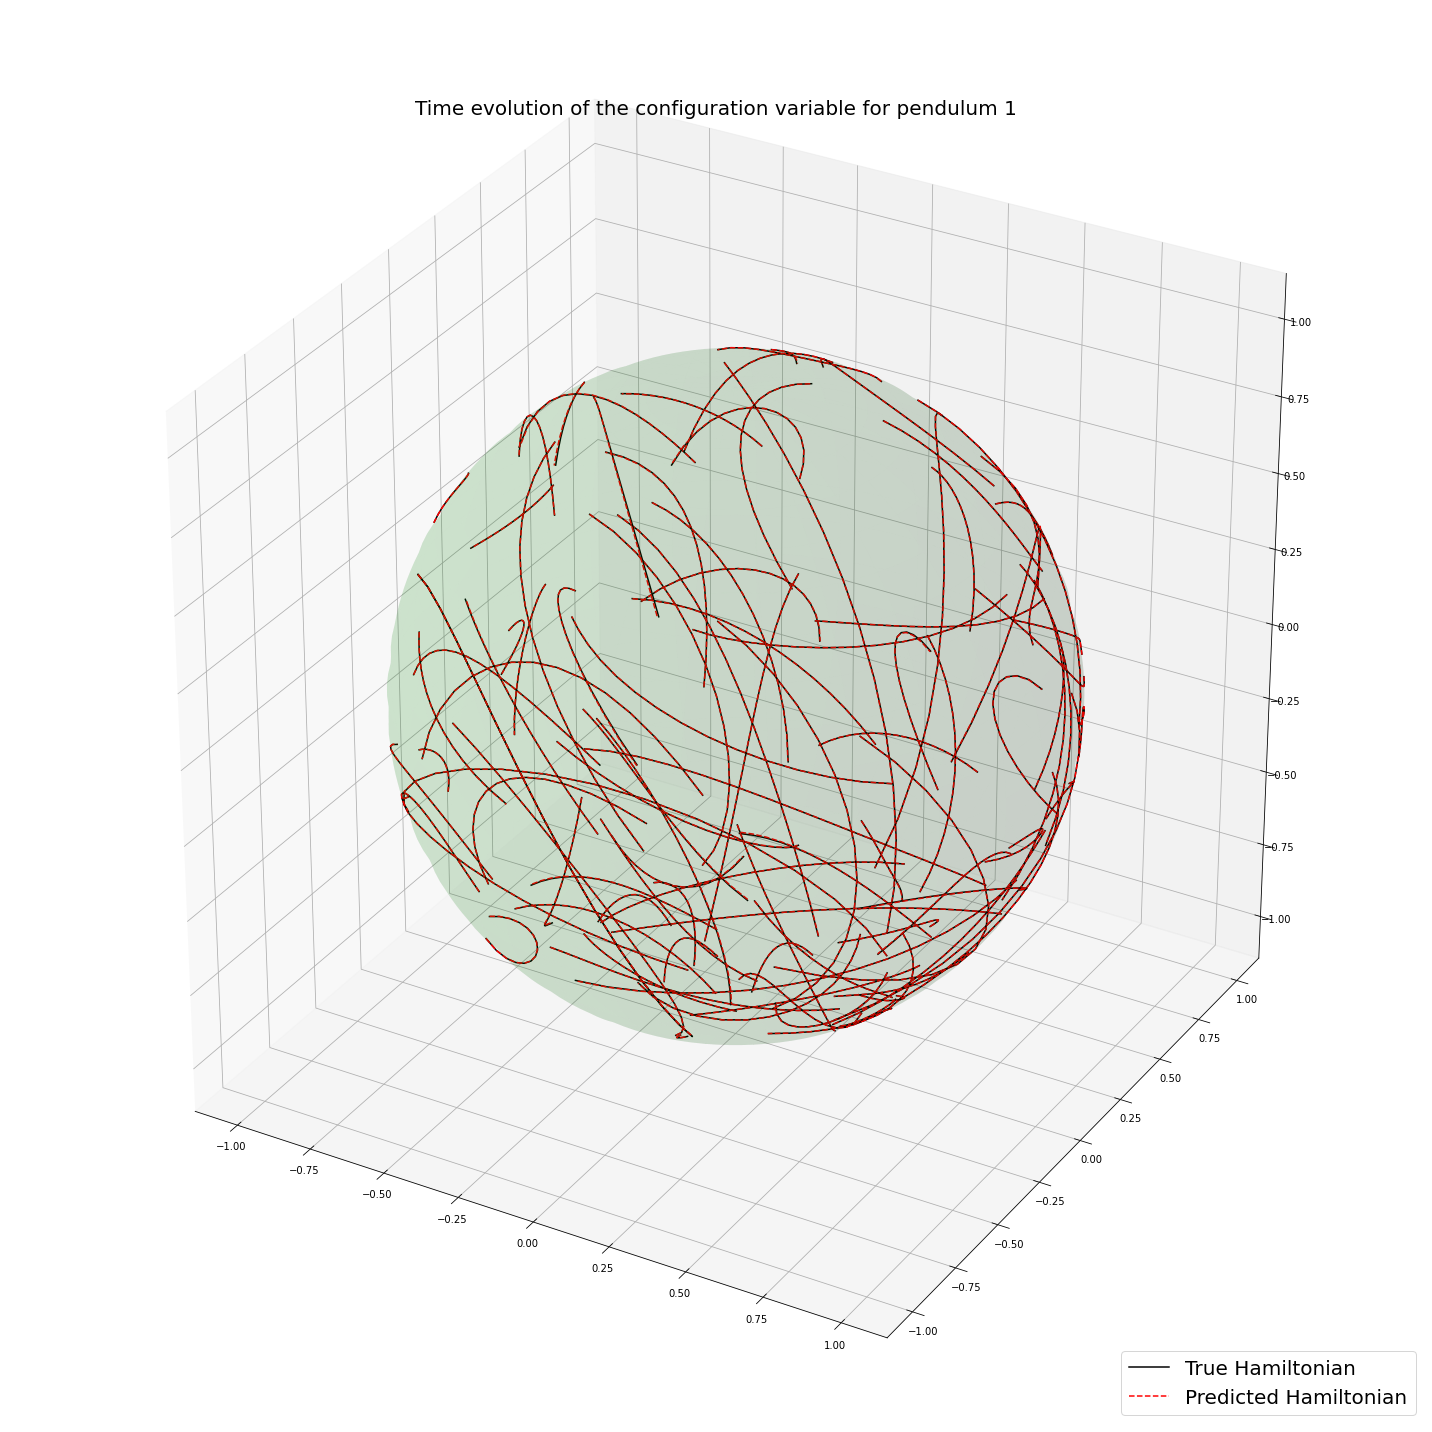

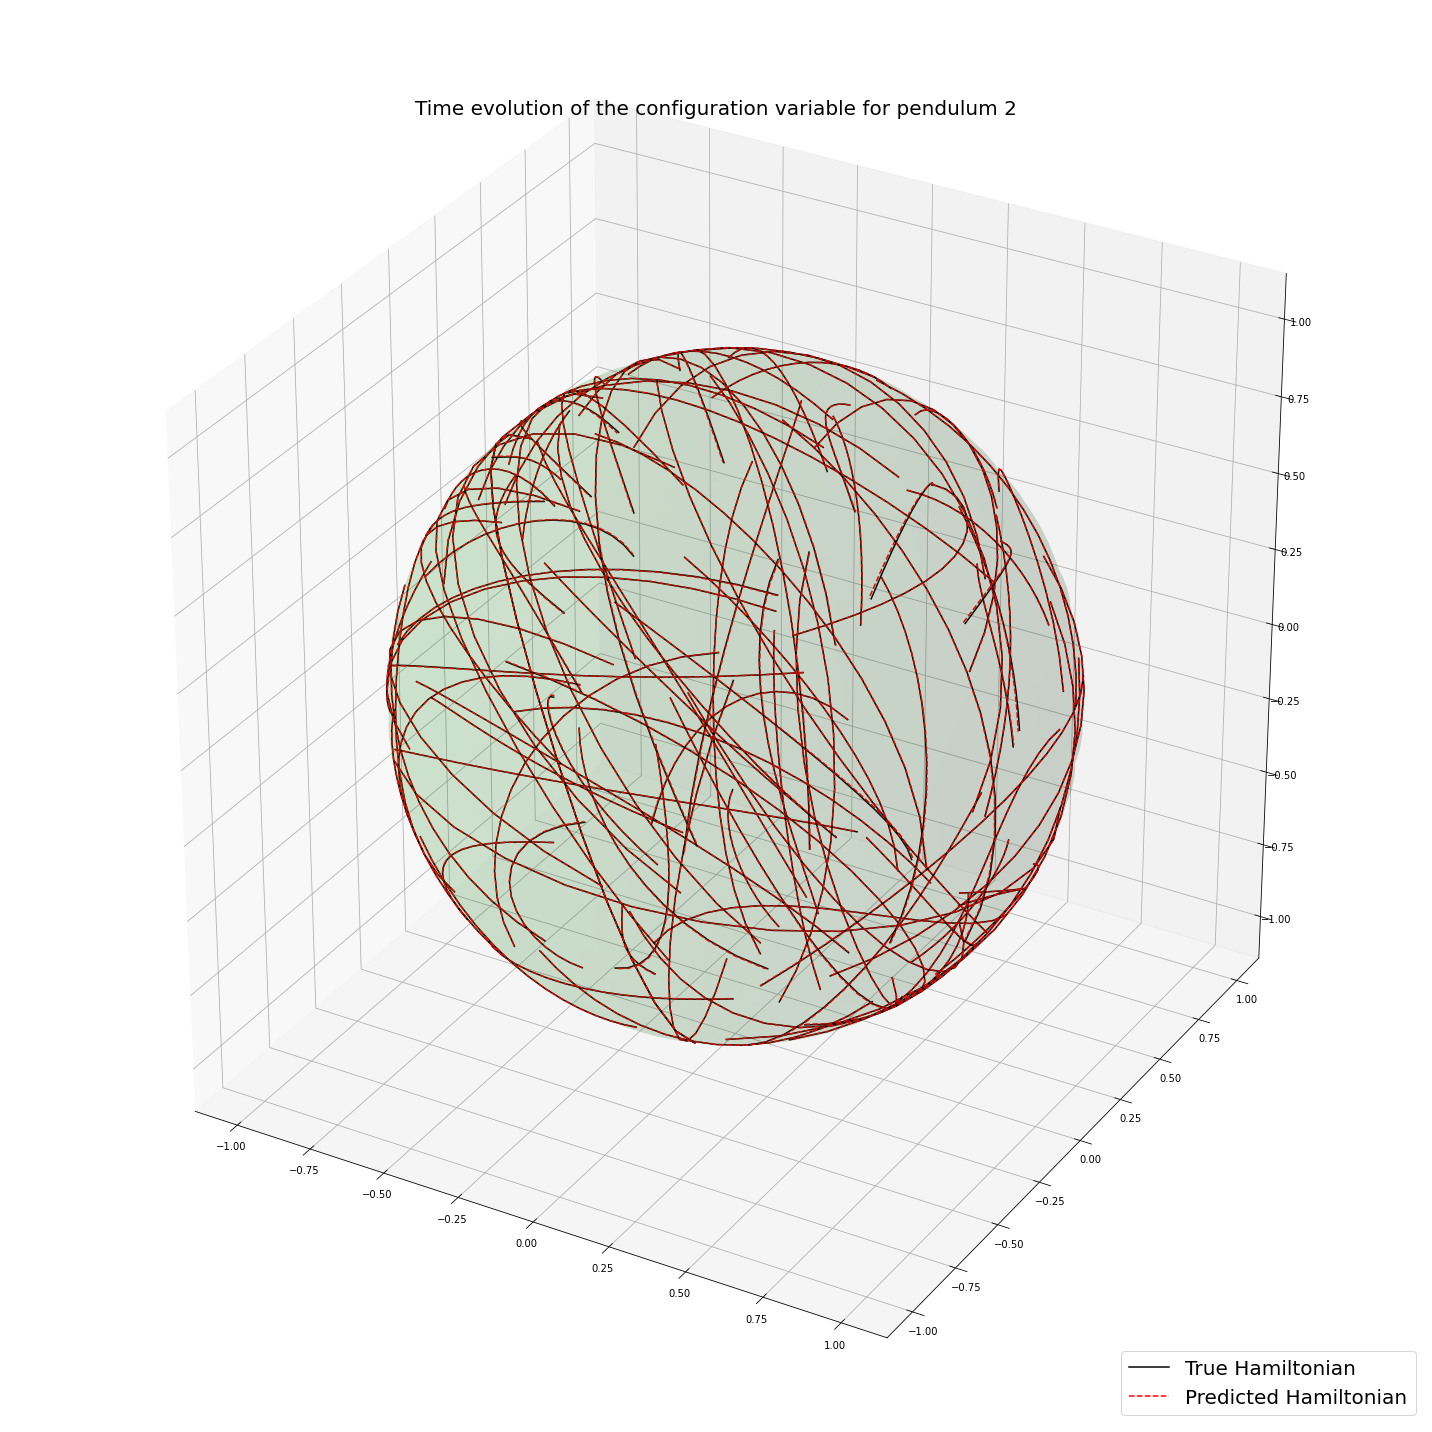

In [37]:
for num in range(nop):
  fig = plt.figure(figsize=(20,20))
  ax = plt.axes(projection='3d')
  ax.plot_surface(x, y, z,  rstride=4, cstride=4, color='g', linewidth=0, alpha=0.09)
  
  ax.plot3D(realTraj[0,6*num,:],realTraj[0,6*num+1,:],realTraj[0,6*num+2,:],'k-',label="True Hamiltonian")
  ax.plot3D(predictedTraj[0,6*num,:],predictedTraj[0,6*num+1,:],predictedTraj[0,6*num+2,:],'r--',label="Predicted Hamiltonian")
  for i in range(Ntest):
    ax.plot3D(realTraj[i,6*num,:],realTraj[i,6*num+1,:],realTraj[i,6*num+2,:],'k-')
    ax.plot3D(predictedTraj[i,6*num,:],predictedTraj[i,6*num+1,:],predictedTraj[i,6*num+2,:],'r--')
  plt.title(f"Time evolution of the configuration variable for pendulum {num+1}",fontsize=20)
  plt.legend(fontsize=20,loc='lower right')

  # ax.set_box_aspect([1,1,1]) 
  # ax.set_proj_type('ortho') 
  set_axes_equal(ax)
  plt.savefig(f"pend{num+1}.png")
  plt.tight_layout()
  plt.show()

In [38]:
print("MSE on test trajectories with RK45 as integrator: ",np.mean((predictedTraj-realTraj)**2))

MSE on test trajectories with RK45 as integrator:  2.1418865577549923e-06
